<a href="https://colab.research.google.com/github/Many98/01NAEX/blob/main/Protokol_EF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01NAEX - Protocol: XGBoost Hyperparameter search




In [ ]:
cat(system('sudo apt-get install -y gmp', intern=TRUE), sep = "\n")
cat(system('sudo apt-get install -y partitions', intern=TRUE), sep = "\n")
cat(system('sudo apt-get install -y DoE.base', intern=TRUE), sep = "\n")

list_of_packages <- c("tidyverse", "car","nortest","lattice","pwr","MASS",
                      "agricolae", "FrF2")
missing_packages <- list_of_packages[!(list_of_packages %in% installed.packages()[,"Package"])]

if(length(missing_packages)) install.packages(missing_packages)
lapply(list_of_packages, library, character.only = TRUE)

# Úvod

V tomto protokole je naším cieľom nájsť optimálne nastavenie hyperparametrov pre algoritmus XGBoost. Konkrétne sa snažíme predikovať cenu bytov v CZK na základe tabulárnych dát.
  Pripravený dataset obsahoval celkovo 8191 vzoriek pričom 85% (6962) dát bolo použitých na tréning
a zvyšných 15% (1229) na test predikčných vlastností modelu. Hodnotenou metrikou je MAE (v CZK). 

Dodatočnými hyperparametrami algoritmu boli napr:

- L2 norma vola použitá ako strátová funkcia
- `tree_method` bola nastavená na `hist` kvôli rýchlosti
- `booster=gbtree`
- `random_state=42`

#### Uvažované úrovne hyperparametrov

(Úrovne tiež definujú horné a spodné hranice pre randomizovaný hyperparameter search)

315K/25K

|       |              **factor** |   **-1** |   **1** | **0 (centerpoint)**   |
|-------|------------------------:|--------:|--------:|-----------------:|
| **A** |           *colsample_bytree* |     0.5 |     1.0 |              0.75 |
| **B** |              *colsample_bynode* |     0.5 |     1.0 |              0.75 |
| **C** |                 *max_depth* |     3 |     15  |             9     |
| **D** |               *learning_rate* | 0.08999 | 0.15 |              0.119995    |
| **E** |*n_estimators* |     100 |     700 |              400 |
| **F** |            *subsample* |     0.5 |      1.0 |          0.75        |
| **G** |            *gamma* |     0.0 |      1.0 |         0.5         |
| **H** |            *max_leaves* |     0 |      100 |              50    |




* max_leaves: 0 or 100
* max_depth: 3 or 15
* learning_rate: 0.08999 or 0.15
* n_estimators: 100 or 700
* gamma: 0 or 1
* subsample: 0.5 or 1
* colsample_bytree: 0.5 or 1
* colsample_bynode: 0.5 or 1	

Na návrh experimentu používame 2^(8-2) dizajn.

Ak označíme faktory naslednovne pričom predpokladáme, že posledné dva nebudú mať významný vplyv na výslednú hodnotu MAE metriky:

*   colsample_bytree - A
*   colsample_bynode - B
*   max_depth	- C
*   learning_rate	- D
*   n_estimators - E	
*   subsample - F	
*   gamma	- G
*   max_leaves - H 

Tak získame takúto štruktúru generátorov: 
 - G = ABCD, H = ABEF

a definujúce vzťahy sú:

 - I = ABCDG = ABEFH = CDEFGH.


A(ABCD) = BCD = BEG = ACDEG
B(ABCD) = ACD = AEG = BCDEG
C(ABCD) = 
  
Rozlišenie modelu (resolution) je teda typu V.

Dodatočne bolo vykonaných 5 replikovaných meraní v centrálnych bodoch.

# TODO

Alternative generators are G = -ABCD, H = -ABEF.

# Použitý dizajn

Bohužial som pozabudol nastaviť konkrétny seed
a preto musíme merania následne preusporiadať

In [2]:
design =FrF2(2^(8-2), 8, replications = 1, randomize = TRUE, seed=42,
generators=c("ABCD","ABEF"), 
factor.names = c("colsample_bytree", "colsample_bynode",
                 "max_depth", "learning_rate", "n_estimators", "subsample",
                 "gamma", "max_leaves")
                 )

# export for later measurement in python
# write.csv(design, "design.csv", row.names=FALSE)
    
head(design)   

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,-1,-1,-1,-1,1,1,1,1
2,-1,-1,1,-1,-1,1,-1,-1
3,-1,-1,-1,-1,-1,-1,1,1
4,-1,-1,-1,1,1,-1,-1,-1
5,1,-1,-1,1,-1,-1,1,-1
6,1,1,-1,-1,-1,1,1,-1


# Namerané dáta podľa (permutácie) vyššie uvedeného dizajnu

In [3]:
measured_design <- read.table("https://raw.githubusercontent.com/Many98/01NAEX/main/naex_design_measure_measure_composite.csv",header=TRUE,sep=",")

head(measured_design, 10)

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae,train_mae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,-1,-1,1,-1,-1,1,-1,-1,164889.9,8864.859
2,1,-1,1,1,1,-1,-1,1,110614.2,2947.114
3,1,-1,-1,1,-1,-1,1,-1,225543.5,156722.187
4,-1,1,1,1,1,-1,-1,1,181386.2,5386.096
5,-1,-1,-1,-1,-1,-1,1,1,366604.9,322576.647
6,-1,1,-1,-1,1,1,-1,-1,121446.5,54506.775
7,-1,-1,1,-1,1,1,-1,1,165075.3,9484.155
8,-1,-1,-1,1,-1,1,-1,-1,283431.2,218493.501
9,-1,1,1,1,-1,1,-1,1,137987.5,35350.215


# Skutočné hodnoty sledovaných hyperparametrov

In [4]:
data <- read.table("https://raw.githubusercontent.com/Many98/01NAEX/main/naex_design_measure_values.csv",header=TRUE,sep=",")
head(data)


,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae,train_mae
,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,0.5,0.5,15,0.08999,100,1.0,0,0,164889.9,8864.859
2,1.0,0.5,15,0.15000,700,0.5,0,100,110614.2,2947.114
3,1.0,0.5,3,0.15000,100,0.5,1,0,225543.5,156722.187
4,0.5,1.0,15,0.15000,700,0.5,0,100,181386.2,5386.096
5,0.5,0.5,3,0.08999,100,0.5,1,100,366604.9,322576.647
6,0.5,1.0,3,0.08999,700,1.0,0,0,121446.5,54506.775


# Korekcia FrF dizajn objektu aby sedel na naše meranie

In [5]:
design$colsample_bytree = measured_design[1:64, 'colsample_bytree']
design$colsample_bynode= measured_design[1:64, 'colsample_bynode']
design$max_depth = measured_design[1:64, 'max_depth']
design$learning_rate = measured_design[1:64, 'learning_rate']
design$n_estimators = measured_design[1:64, 'n_estimators']
design$subsample = measured_design[1:64, 'subsample']
design$gamma = measured_design[1:64, 'gamma']
design$max_leaves = measured_design[1:64, 'max_leaves']


# Adding response (testing mean absolute error) to the design
test_mae = measured_design[1:64, 'test_mae']
design = add.response(design, test_mae)

# now it corresponds to measured data
head(design)

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,-1,-1,1,-1,-1,1,-1,-1,164889.9
2,1,-1,1,1,1,-1,-1,1,110614.2
3,1,-1,-1,1,-1,-1,1,-1,225543.5
4,-1,1,1,1,1,-1,-1,1,181386.2
5,-1,-1,-1,-1,-1,-1,1,1,366604.9
6,-1,1,-1,-1,1,1,-1,-1,121446.5


In [6]:
summary(design)

Call:
FrF2(2^(8 - 2), 8, replications = 1, randomize = TRUE, seed = 42, 
    generators = c("ABCD", "ABEF"), factor.names = c("colsample_bytree", 
        "colsample_bynode", "max_depth", "learning_rate", "n_estimators", 
        "subsample", "gamma", "max_leaves"))

Experimental design of type  FrF2.generators 
64  runs

Factor settings (scale ends):
  colsample_bytree colsample_bynode max_depth learning_rate n_estimators
1               -1               -1        -1            -1           -1
2                1                1         1             1            1
  subsample gamma max_leaves
1        -1    -1         -1
2         1     1          1

Responses:
[1] test_mae

Design generating information:
$legend
[1] A=colsample_bytree B=colsample_bynode C=max_depth        D=learning_rate   
[5] E=n_estimators     F=subsample        G=gamma            H=max_leaves      

$generators
[1] G=ABCD H=ABEF


Alias structure:
[[1]]
[1] no aliasing among main effects and 2fis



# Hlavné efekty jednotlivých faktorov

In [ ]:
df_long <- design %>% gather(key = "Factor", value = "Value", -test_mae)

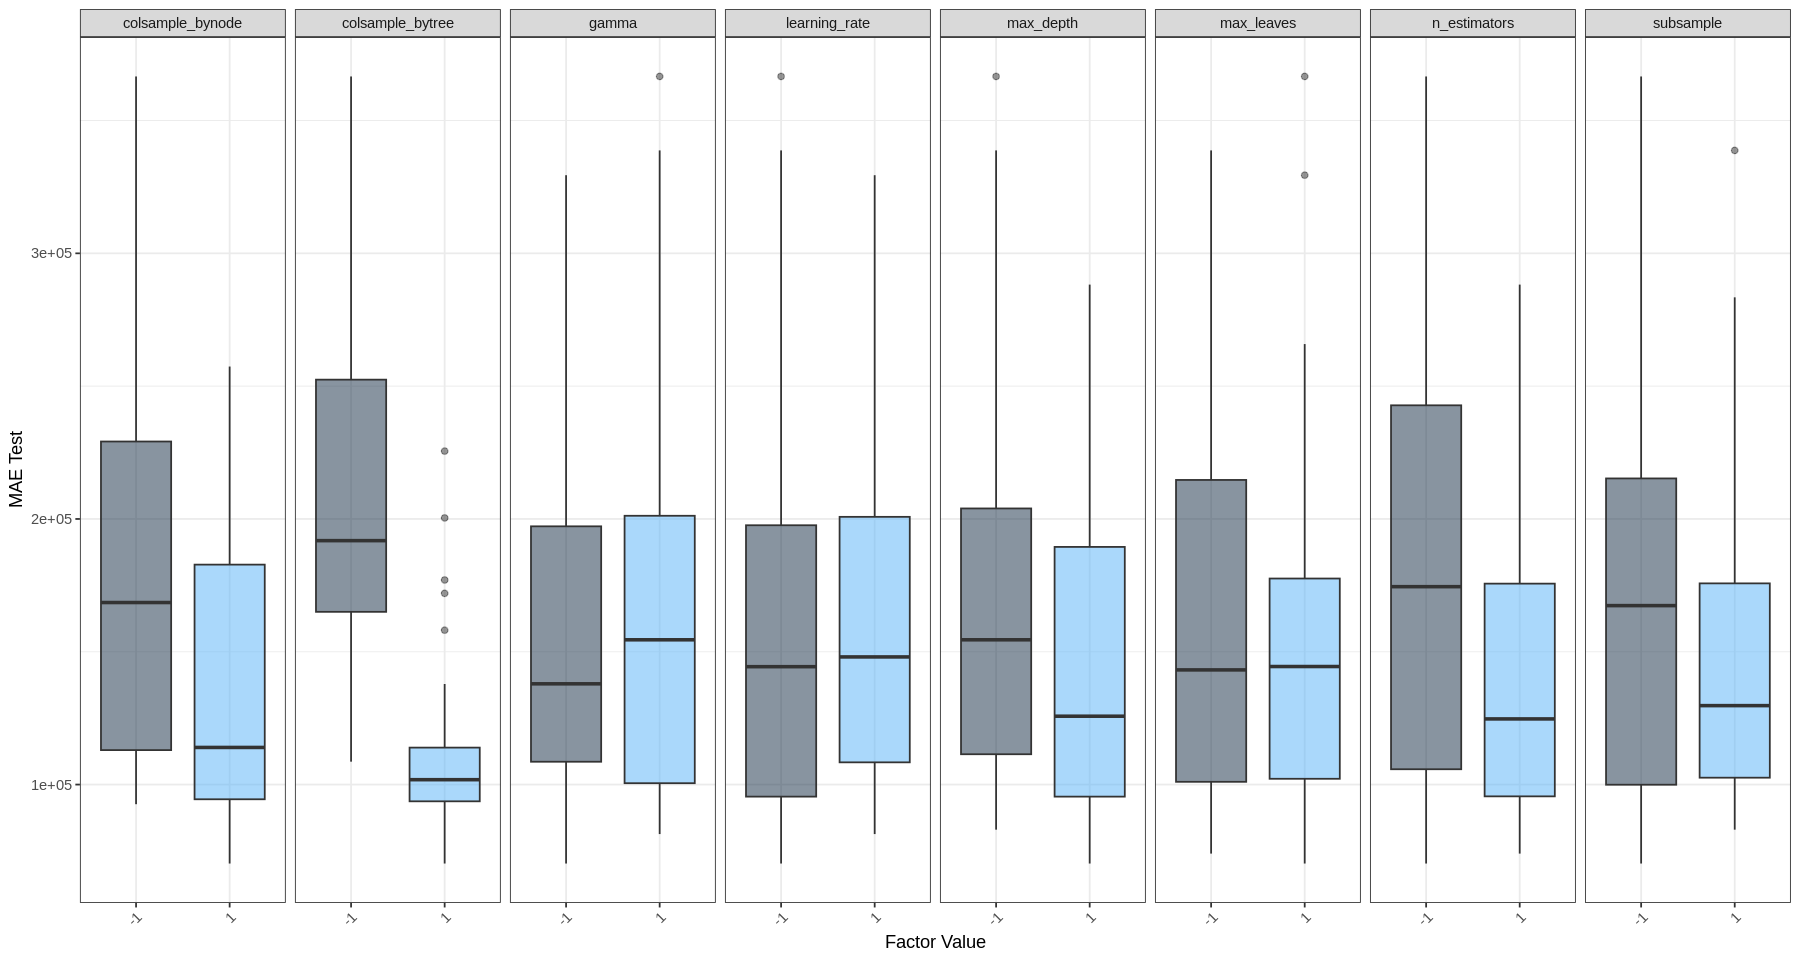

In [ ]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(df_long, aes(x = factor(Value), y = test_mae, fill = Value)) +
  geom_boxplot(alpha=0.5) +
  facet_grid(. ~ Factor, shrink=FALSE) +
  labs(x = "Factor Value", y = "MAE Test") +
  theme_bw() +
  theme(legend.position = "none") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

In [ ]:
anova <- aov(test_mae~.,design)
summary(anova)

                 Df    Sum Sq   Mean Sq F value   Pr(>F)    
colsample_bytree  1 1.455e+11 1.455e+11  92.359 2.27e-13 ***
colsample_bynode  1 3.370e+10 3.370e+10  21.389 2.32e-05 ***
max_depth         1 8.819e+09 8.819e+09   5.598   0.0215 *  
learning_rate     1 1.743e+08 1.743e+08   0.111   0.7407    
n_estimators      1 3.264e+10 3.264e+10  20.716 2.99e-05 ***
subsample         1 6.653e+09 6.653e+09   4.223   0.0446 *  
gamma             1 6.210e+08 6.210e+08   0.394   0.5327    
max_leaves        1 6.053e+08 6.053e+08   0.384   0.5379    
Residuals        55 8.665e+10 1.575e+09                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
lm_for_coeffs <- lm(test_mae~., data=design)
effects <-as.data.frame(2*lm_for_coeffs$coefficients)
names(effects)[1] <- 'Main Effects'
head(effects, 9)

,Main Effects
,<dbl>
(Intercept),321002.763
colsample_bytree,-95362.753
colsample_bynode,-45891.384
max_depth,-23477.622
learning_rate,3300.787
n_estimators,-45163.869
subsample,-20391.602
gamma,6230.058
max_leaves,-6150.659


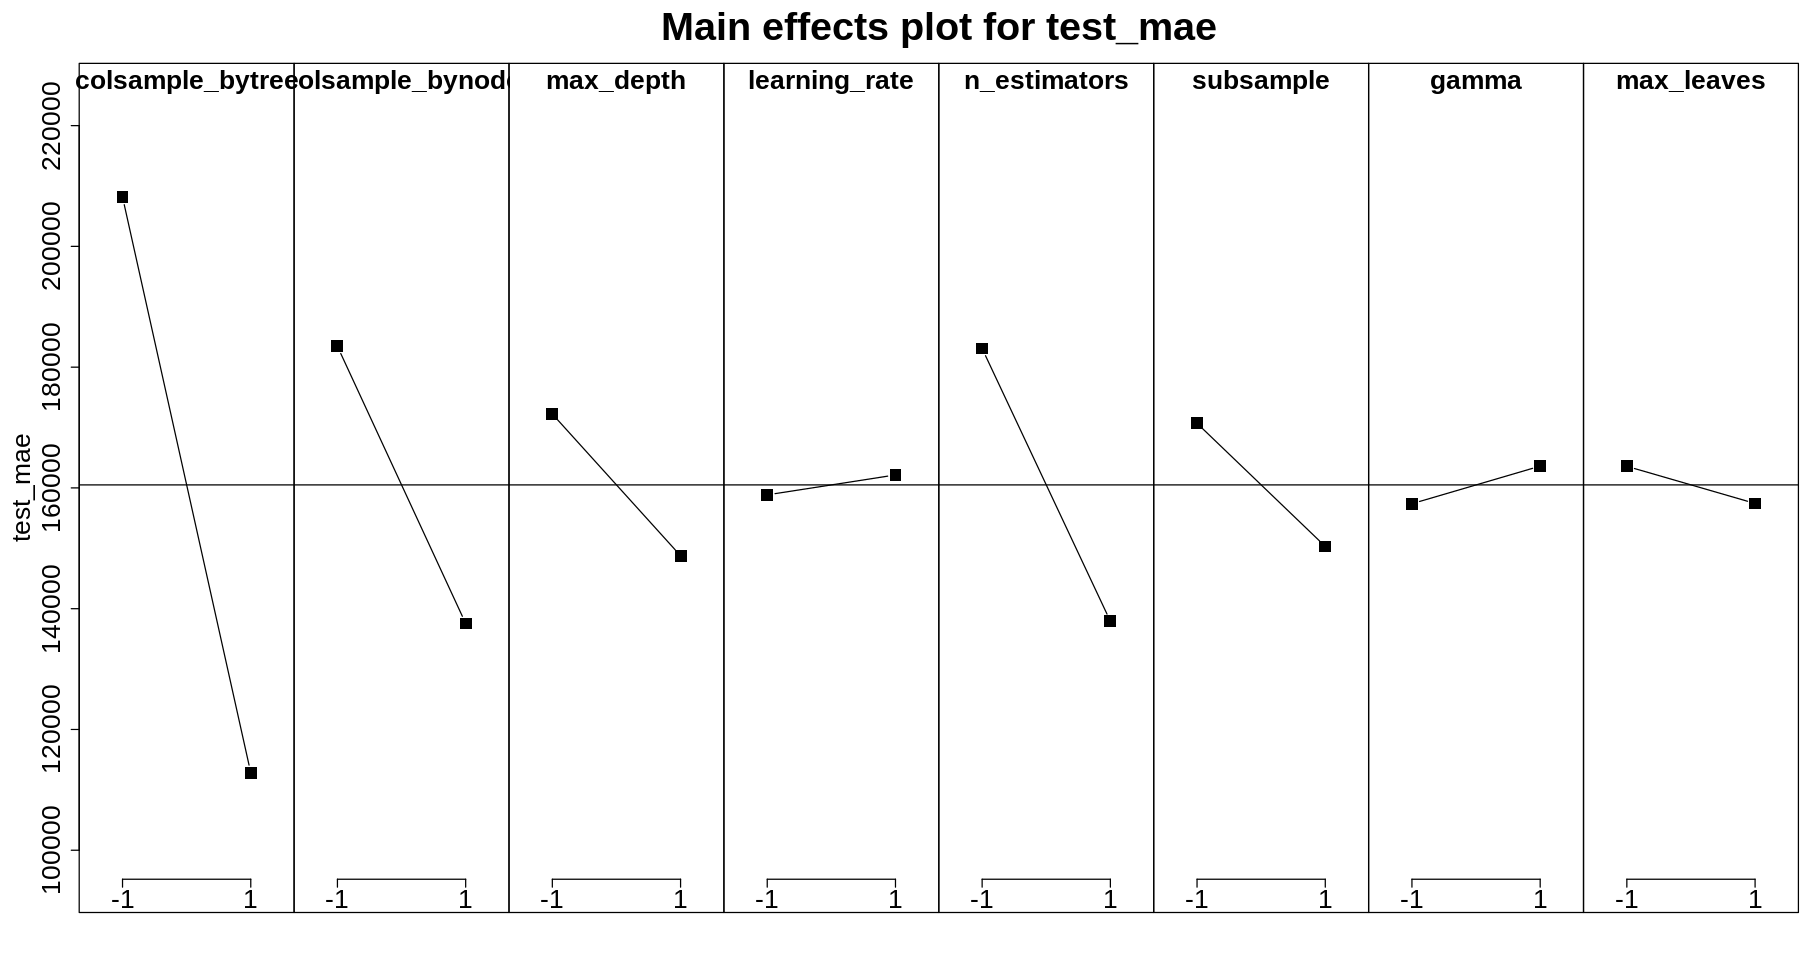

In [ ]:
MEPlot(design, cex.xax = 2, cex.main = 2)

Graf hlavných efektov poukazuje na to, že medzi navplyvnejšie
faktory patrí `colsample_bytree`, `colsample_bynode`, a `n_estimators`. Nutné je dodať, že takáto interpretácia v zmysle hlavných efektov bude možné len v prípade, že interakcie nebudú pozorované. Pokračujme teda grafickou analýzou interakcii.


# Grafická analýza významných faktorov a ich interakcii

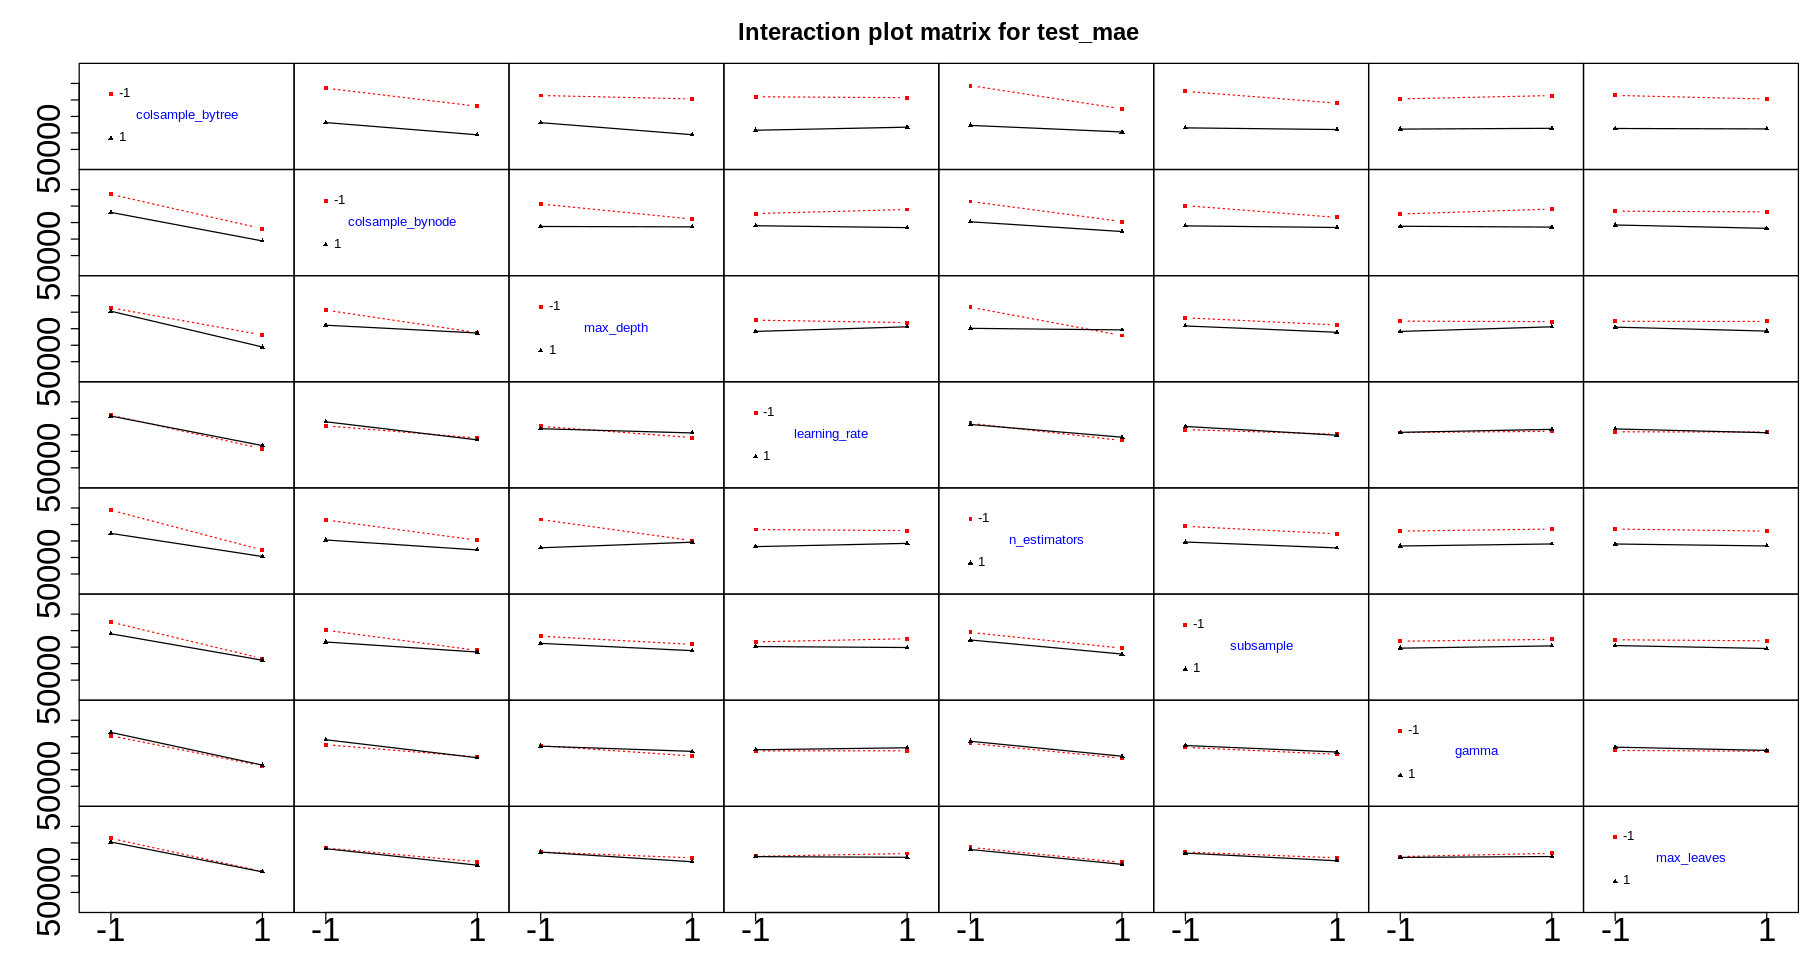

In [ ]:
IAPlot(design, cex.xax = 2.5, cex.main = 2.5)

Podľa interakčného grafu sa zdá, že `colsample_bytree`, `colsample_bynode`, a `n_estimators` faktory vykazujú čiastočné interakcie prvého rádu so všetkými ostatnými skúmanými faktormi. Verifikácie tejto hypotézy bude vykonaná pomocou ANOVA analýzy.


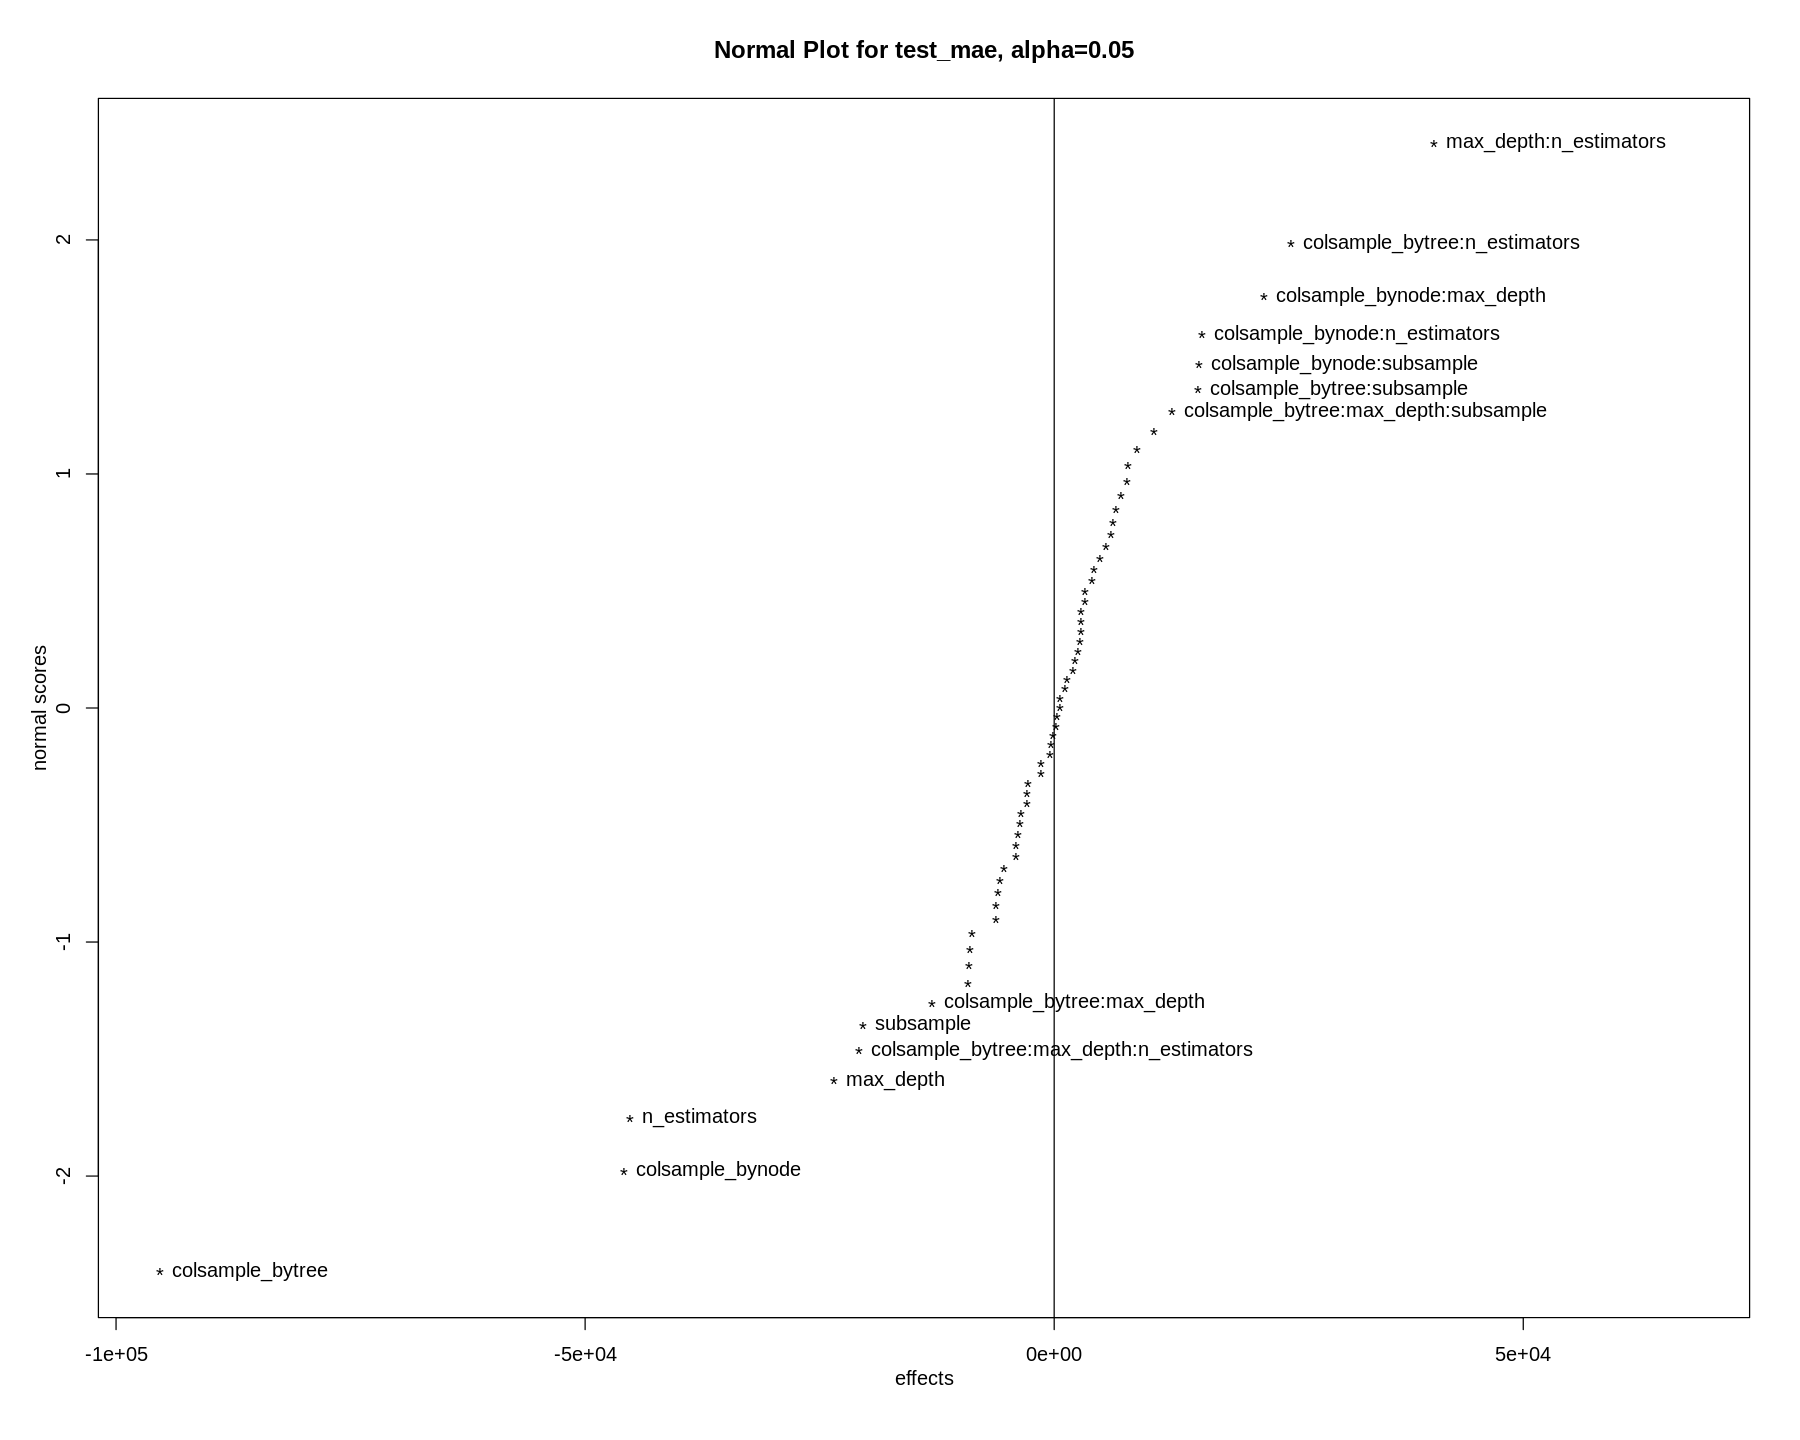

In [ ]:
# Daniel plot
options(repr.plot.width=15, repr.plot.height=12)

DP = DanielPlot(design)
qqline(DanielPlot(design)$y)


Podľa teórie patria medzi významné faktory tie ktoré sa výrazne ďaleko od `normálnej priamky` a teda v našom prípade tento graf opäť okrem iného poukazuje na významnosť faktorov
`colsample_bytree`, `colsample_bynode`, `n_estimators` a tiež niektorých interakcii ako napr. `max_depth:n_estimators` čo sa týka ich vplyvu na výslednú hodnotu testovacej metriky MAE. 


In [ ]:
# alternative to extract main effects from Daniel plot

effects <- cbind(DP$effect, DP$x)
effects[1:9,]

colsample_bytree,-95362.7532673922
colsample_bynode,-45891.3835943857
max_depth,-23477.6216499695
learning_rate,3300.78653885274
n_estimators,-45163.8687830553
subsample,-20391.6020646867
gamma,6230.05768155003
max_leaves,-6150.65895163751
colsample_bytree:colsample_bynode,8805.09308253661


# ANOVA

Najprv nafitujeme model so všetkými premennými ich interakciami prvého rádu.

In [ ]:
# Resolution V factorial design means that 3 way interactions are aliased
# with 2 way interactions, hence we can't estimate them. 
#Any higher interaction is then also aliased.
# First attempt model:
summary(aov(test_mae~ (.)^2 +
                     colsample_bytree:max_depth:subsample +
                     colsample_bytree:max_depth:n_estimators, data=design))

                                        Df    Sum Sq   Mean Sq F value   Pr(>F)
colsample_bytree                         1 1.455e+11 1.455e+11 474.971  < 2e-16
colsample_bynode                         1 3.370e+10 3.370e+10 109.995 1.22e-10
max_depth                                1 8.819e+09 8.819e+09  28.788 1.45e-05
learning_rate                            1 1.743e+08 1.743e+08   0.569  0.45769
n_estimators                             1 3.264e+10 3.264e+10 106.535 1.69e-10
subsample                                1 6.653e+09 6.653e+09  21.718 8.99e-05
gamma                                    1 6.210e+08 6.210e+08   2.027  0.16687
max_leaves                               1 6.053e+08 6.053e+08   1.976  0.17214
colsample_bytree:colsample_bynode        1 1.240e+09 1.240e+09   4.049  0.05508
colsample_bytree:max_depth               1 2.711e+09 2.711e+09   8.849  0.00642
colsample_bytree:learning_rate           1 5.792e+08 5.792e+08   1.891  0.18133
colsample_bytree:n_estimators           

In [ ]:

# Next Model
summary(aov(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth + n_estimators +
        
                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators + 
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +  
                     colsample_bynode:n_estimators + 
                      colsample_bynode:subsample +
                        colsample_bynode:learning_rate+
                      max_depth:n_estimators +
                      max_depth:learning_rate+
                     colsample_bytree:max_depth:subsample +
                     colsample_bytree:max_depth:n_estimators, data=design))

                                        Df    Sum Sq   Mean Sq F value   Pr(>F)
colsample_bytree                         1 1.455e+11 1.455e+11 405.866  < 2e-16
colsample_bynode                         1 3.370e+10 3.370e+10  93.991 8.62e-13
subsample                                1 6.653e+09 6.653e+09  18.558 8.34e-05
max_depth                                1 8.819e+09 8.819e+09  24.600 9.63e-06
n_estimators                             1 3.264e+10 3.264e+10  91.035 1.43e-12
colsample_bytree:max_depth               1 2.711e+09 2.711e+09   7.561  0.00844
colsample_bytree:n_estimators            1 1.023e+10 1.023e+10  28.523 2.64e-06
colsample_bytree:subsample               1 3.749e+09 3.749e+09  10.458  0.00224
colsample_bynode:max_depth               1 7.992e+09 7.992e+09  22.291 2.14e-05
colsample_bynode:n_estimators            1 3.954e+09 3.954e+09  11.028  0.00174
colsample_bynode:subsample               1 3.825e+09 3.825e+09  10.669  0.00204
colsample_bynode:learning_rate          

Po nafitovaní modelu sa zdá, že interakcia `colsample_bynode:learning_rate` už nie je významná preto ju vylúčime z finálneho modelu

In [ ]:
# Final Model

final_model <- aov(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth + n_estimators +
        
                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators + 
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +  
                     colsample_bynode:n_estimators + 
                      colsample_bynode:subsample +
                      max_depth:n_estimators +
                      max_depth:learning_rate+
                     colsample_bytree:max_depth:subsample +
                     colsample_bytree:max_depth:n_estimators, data=design)
summary(final_model)

                                        Df    Sum Sq   Mean Sq F value   Pr(>F)
colsample_bytree                         1 1.455e+11 1.455e+11 384.761  < 2e-16
colsample_bynode                         1 3.370e+10 3.370e+10  89.104 1.62e-12
subsample                                1 6.653e+09 6.653e+09  17.593 0.000117
max_depth                                1 8.819e+09 8.819e+09  23.321 1.44e-05
n_estimators                             1 3.264e+10 3.264e+10  86.301 2.67e-12
colsample_bytree:max_depth               1 2.711e+09 2.711e+09   7.168 0.010126
colsample_bytree:n_estimators            1 1.023e+10 1.023e+10  27.040 4.07e-06
colsample_bytree:subsample               1 3.749e+09 3.749e+09   9.915 0.002819
colsample_bynode:max_depth               1 7.992e+09 7.992e+09  21.132 3.13e-05
colsample_bynode:n_estimators            1 3.954e+09 3.954e+09  10.455 0.002215
colsample_bynode:subsample               1 3.825e+09 3.825e+09  10.115 0.002577
max_depth:n_estimators                  

Pomocou ANOVA analýzy sme dospeli k veľmi podobným záverom ohľadom modelu ako v prípade grafickej analýzy. Vidíme, že na výslednú hodnotu metriky MAE nevplývajú len hlavné efekty pár faktorov ale aj ich interakcie prvého a druhého rádu čo významne sťažuje interpretabilitu jednotlivých faktorov. Našou úlohou ale nie je interpretovať účinok jednotlivých faktorov ale nájsť vhodný model na lineárnu aproximáciu response funkcie ktorou je v našom prípade MAE metrika.

# Predpoklady modelu

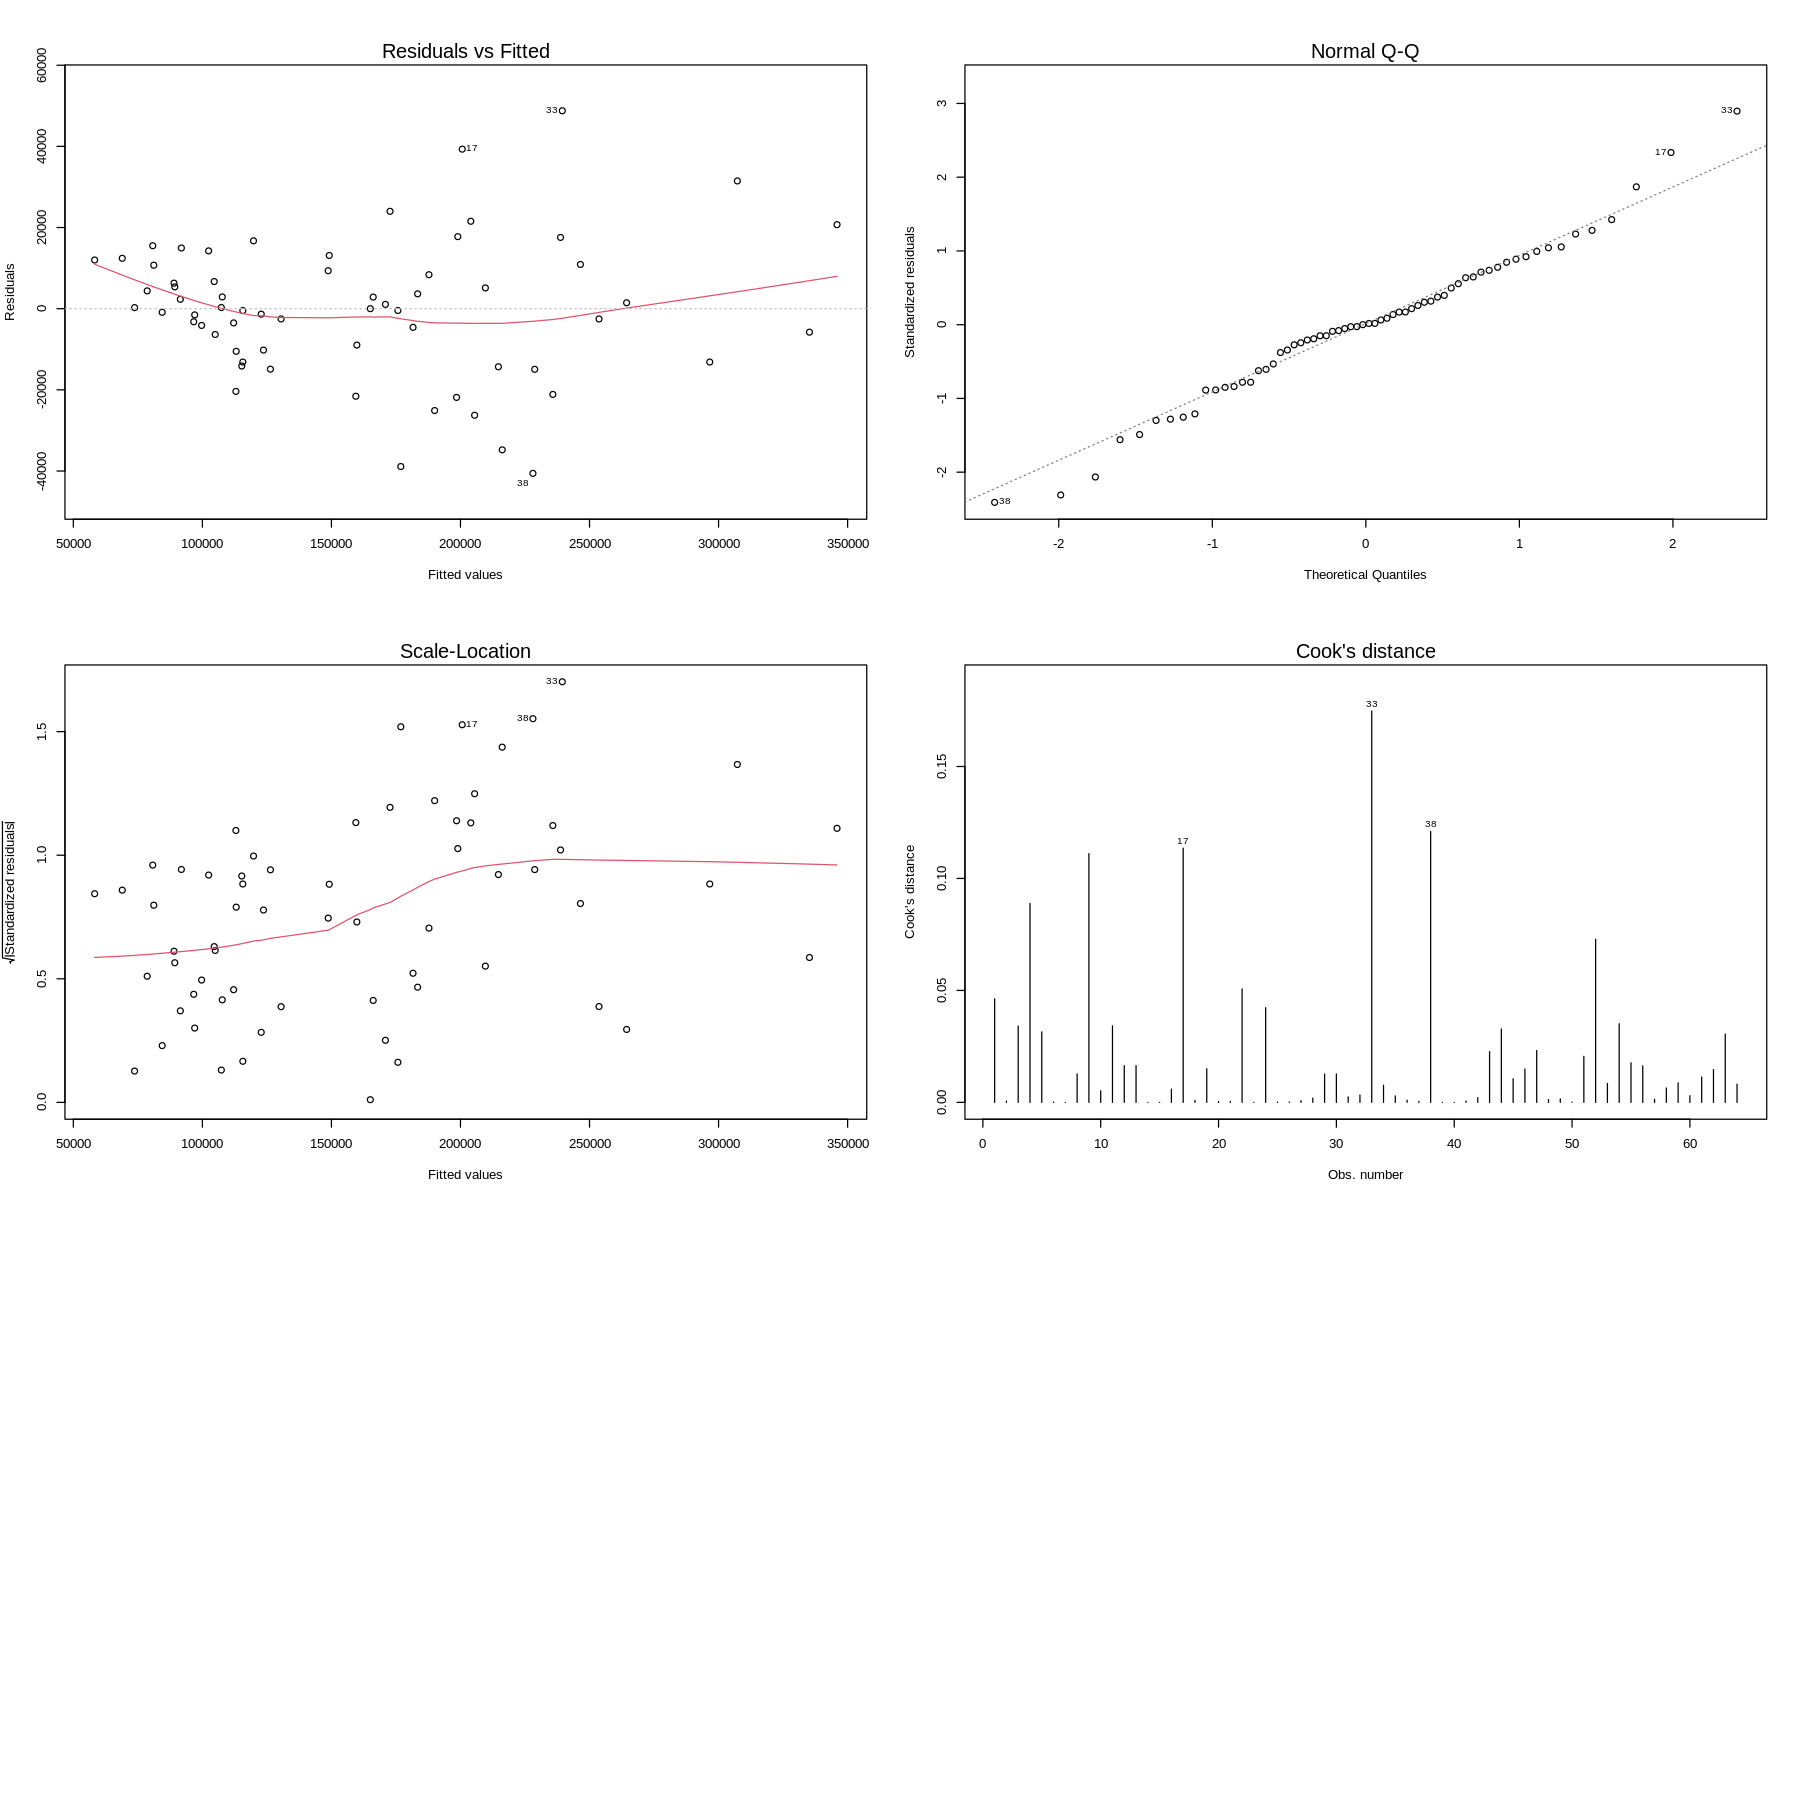

In [ ]:
par(mfrow = c(3,2))
options(repr.plot.width = 15, repr.plot.height = 15)

plot(final_model, which=c(1,2,3,4))

# Test lineárnej závislosti pomocou meraní v centrálnych bodoch

Keďže už máme určený finálny linárny model, môžme použiť dáta aby sme overili či závislosť MAE nie je ovplyvnená aj kvadratickými závislosťami jednotlivých faktorov. Na toto použijeme dodatočné merania v centrálnych bodoch.

In [ ]:
# dataframe with center point measurements only
data_center = measured_design[65:69, ]
data_center

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae,train_mae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
65,0,0,0,0,0,0,0,0,100885.3,10149.37
66,0,0,0,0,0,0,0,0,100885.3,10149.37
67,0,0,0,0,0,0,0,0,100885.3,10149.37
68,0,0,0,0,0,0,0,0,100885.3,10149.37
69,0,0,0,0,0,0,0,0,100885.3,10149.37


In [ ]:
mean_mae = mean(design$test_mae)
mean_center = mean(data_center$test_mae)


mean_mae - mean_center

ss_pure_quadratic = (64*5)*(mean_center-mean_mae)*(mean_center-mean_mae) / (64+5)

#ss_pure_quadratic

[1] 59616.1

Vidíme, že rozdiel priemernej odozvy v centrálnych bodoch a priemernej odozvy ostatných meraní je zhruba 60000 čo poukazuje na to, že závislosť nie je čisto lineárna.

In [9]:
isCenter = c(rep(0,times=64),rep(1,times=5), rep(0,times=16))
measured_design$isCenter = isCenter

summary(aov(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth + n_estimators +
                      isCenter+
                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators + 
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +  
                     colsample_bynode:n_estimators + 
                      colsample_bynode:subsample +
                      max_depth:n_estimators +
                      max_depth:learning_rate+
                     colsample_bytree:max_depth:subsample +
                     colsample_bytree:max_depth:n_estimators, data=measured_design[1:69, ]))
                   
              

                                        Df    Sum Sq   Mean Sq F value   Pr(>F)
colsample_bytree                         1 1.455e+11 1.455e+11 416.825  < 2e-16
colsample_bynode                         1 3.370e+10 3.370e+10  96.529 1.91e-13
subsample                                1 6.653e+09 6.653e+09  19.059 6.05e-05
max_depth                                1 8.819e+09 8.819e+09  25.264 6.28e-06
n_estimators                             1 3.264e+10 3.264e+10  93.493 3.28e-13
isCenter                                 1 1.648e+10 1.648e+10  47.218 7.93e-09
colsample_bytree:max_depth               1 2.711e+09 2.711e+09   7.766  0.00742
colsample_bytree:n_estimators            1 1.023e+10 1.023e+10  29.293 1.60e-06
colsample_bytree:subsample               1 3.749e+09 3.749e+09  10.741  0.00187
colsample_bynode:max_depth               1 7.992e+09 7.992e+09  22.893 1.46e-05
colsample_bynode:n_estimators            1 3.954e+09 3.954e+09  11.326  0.00144
colsample_bynode:subsample              

Výsledok ANOVA analýzy potrvrdzuje, že závislosť MAE metriky na faktoroch nie je čisto lineárna ale obsahuje aj 
kvadratické členy.

# Lineárny model

Nakoľko predchadzajúca ANOVA analýza poukazuje na kvadratickú závislosť tak sa pokúsime nafitovať nový lineárny model aj s kvadratickými členmi. Pre tento účel bolo vykonaných dodatočných 16 meraní pomocou center composite dizajnu. 


In [12]:
lin_model <- lm(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth +
                      n_estimators +
                      
                      I(max_depth^2)+
                        #I(n_estimators^2)+
                        #I(subsample^2)+
                        I(colsample_bynode^2) + #I(colsample_bytree^2)+
                    
                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators + 
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +  
                     colsample_bynode:n_estimators + 
                      colsample_bynode:subsample +
                      max_depth:n_estimators +
                      max_depth:learning_rate+
                     colsample_bytree:max_depth:subsample +
                     colsample_bytree:max_depth:n_estimators
                   , data=measured_design) # data[1:64,]

        
summary(lin_model)


Call:
lm.default(formula = test_mae ~ colsample_bytree + colsample_bynode + 
    subsample + max_depth + n_estimators + I(max_depth^2) + I(colsample_bynode^2) + 
    colsample_bytree:max_depth + colsample_bytree:n_estimators + 
    colsample_bytree:subsample + colsample_bynode:max_depth + 
    colsample_bynode:n_estimators + colsample_bynode:subsample + 
    max_depth:n_estimators + max_depth:learning_rate + colsample_bytree:max_depth:subsample + 
    colsample_bytree:max_depth:n_estimators, data = measured_design)

Residuals:
   Min     1Q Median     3Q    Max 
-47931 -10556   -730   9809  49745 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                               101615       4784  21.238  < 2e-16
colsample_bytree                          -46226       2498 -18.508  < 2e-16
colsample_bynode                          -22804       2498  -9.131 2.23e-13
subsample                                 -10166       2498  -4.071 0.0

Zdá sa teda, že závislosť je kvadratická v `colsample_bynode` a `max_depth` premennej. Aby sme mohli v ďalšej analýze použiť aproximáciu kvadratickou závislosťou tak vylúčime interakcie druhého rádu, konkrétne `colsample_bytree:subsample:max_depth` a `colsample_bytree:max_depth:n_estimators`. Aj bez týchto členov model dáva relatívne vysokú hodnotu R2.

In [31]:
final_lin_model <- lm(test_mae~colsample_bytree +
                      colsample_bynode +
                      subsample + max_depth +
                      n_estimators +

                      # add other (non-significant)factors for quadrature
                      # -----------------------
                        I(n_estimators^2)+
                        I(subsample^2)+
                       I(colsample_bytree^2)+
                       colsample_bytree:colsample_bynode+
                       max_depth:subsample+
                       n_estimators:subsample+
                    #---------------------------
                      
                     colsample_bytree:max_depth +
                      colsample_bytree:n_estimators + 
                      colsample_bytree:subsample +
                      colsample_bynode:max_depth +  
                     colsample_bynode:n_estimators + 
                      colsample_bynode:subsample +
                      max_depth:n_estimators +
                  

                     I(colsample_bynode^2)+
                      I(max_depth^2)
                     #colsample_bytree:max_depth:subsample +
                     #colsample_bytree:max_depth:n_estimators
                   , data=measured_design) # <- data with center and center composite design

        
summary(final_lin_model)


Call:
lm.default(formula = test_mae ~ colsample_bytree + colsample_bynode + 
    subsample + max_depth + n_estimators + I(n_estimators^2) + 
    I(subsample^2) + I(colsample_bytree^2) + colsample_bytree:colsample_bynode + 
    max_depth:subsample + n_estimators:subsample + colsample_bytree:max_depth + 
    colsample_bytree:n_estimators + colsample_bytree:subsample + 
    colsample_bynode:max_depth + colsample_bynode:n_estimators + 
    colsample_bynode:subsample + max_depth:n_estimators + I(colsample_bynode^2) + 
    I(max_depth^2), data = measured_design)

Residuals:
   Min     1Q Median     3Q    Max 
-52030 -11262  -1442  11915  68998 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       100601.5     5767.8  17.442  < 2e-16 ***
colsample_bytree                  -46225.9     2958.1 -15.627  < 2e-16 ***
colsample_bynode                  -22804.3     2958.1  -7.709 1.05e-10 ***
subsample                         -10

In [34]:
 # full quadratic model
 # cs_bt, cs_bn, sub, m_d, n_estim
 b = matrix(c(final_lin_model$coeff[2],final_lin_model$coeff[3], final_lin_model$coeff[4],
             final_lin_model$coeff[5], final_lin_model$coeff[6]),5,1)
          #   colsample_bytree             colsample_bynode               subsample                 max_depth                     n_estimators        
 B = matrix(c(final_lin_model$coeff[9], final_lin_model$coeff[12]/2, final_lin_model$coeff[17]/2, final_lin_model$coeff[15]/2, final_lin_model$coeff[16]/2,
              final_lin_model$coeff[12]/2, final_lin_model$coeff[10], final_lin_model$coeff[20]/2, final_lin_model$coeff[18]/2 ,final_lin_model$coeff[19]/2,
              final_lin_model$coeff[17]/2, final_lin_model$coeff[20]/2,final_lin_model$coeff[8],final_lin_model$coeff[13]/2,final_lin_model$coeff[14]/2,
              final_lin_model$coeff[15]/2, final_lin_model$coeff[18]/2,final_lin_model$coeff[13]/2,final_lin_model$coeff[11],final_lin_model$coeff[21]/2,
              final_lin_model$coeff[16]/2,final_lin_model$coeff[19]/2, final_lin_model$coeff[14]/2, final_lin_model$coeff[21]/2, final_lin_model$coeff[7])
              
              ,5,5)
b
B

-46225.89
-22804.30
-10166.31
-11307.37
-21897.63


5112.896,2201.273,3827.0175,-3254.0910,6320.1275
2201.273,22750.413,3865.4426,5587.2214,3929.9388
3827.018,3865.443,7098.6548,337.7518,629.1499
-3254.091,5587.221,337.7518,19028.8510,10111.4659
6320.128,3929.939,629.1499,10111.4659,5738.6407


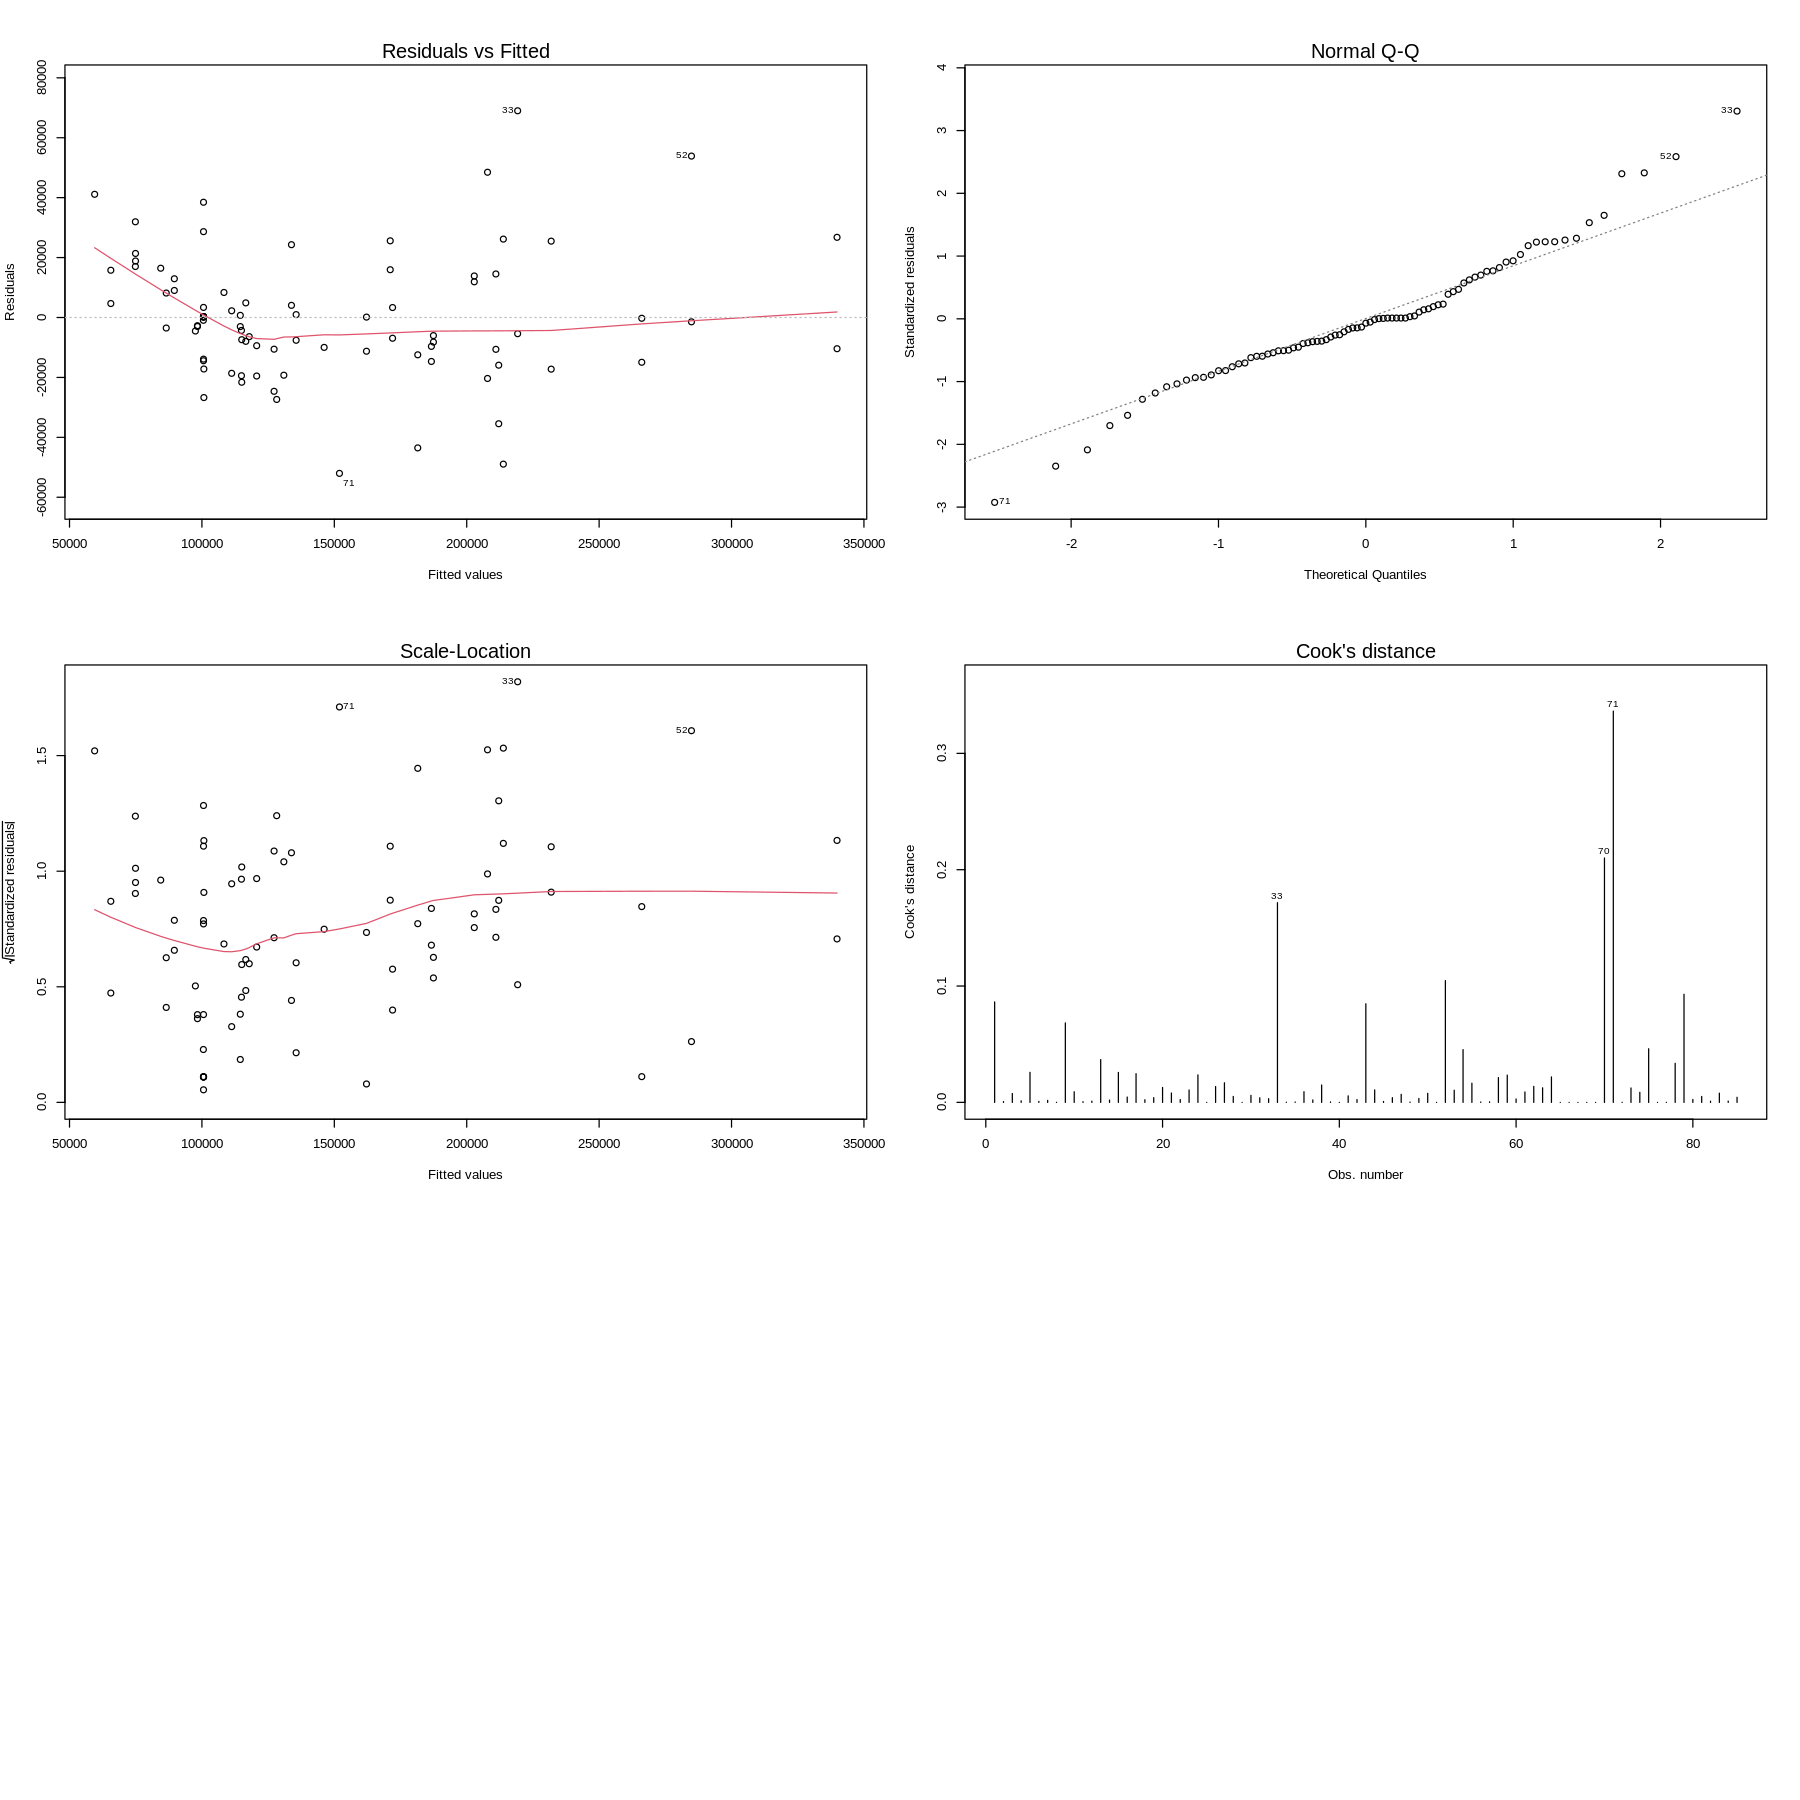

In [32]:
par(mfrow = c(3,2))
options(repr.plot.width = 15, repr.plot.height = 15)

plot(final_lin_model, which=c(1,2,3,4))

Graf residual vs fitted nevykazuje značné vzory. Na druhú stranu QQ-plot poukazuje na to, že rezidua prislúchajúce pozorovaniam 33 a 52 sa mierne odlišujú od očakávanej normálnej distribúcie. Tieto dve pozorovania sú zároveň pákovými bodmi. Celkovo ale nevidím dôvod ich vylučovať z analýzy.

In [ ]:
#mapped_data <- data %>% mutate(
#                           colsample_bytree = (colsample_bytree-0.75)/0.25,
#                           colsample_bynode = (colsample_bynode-0.75)/0.25,
#                           subsample = (subsample-0.75)/0.25,
#                           max_depth = (max_depth-9)/6,
#                           n_estimators = (n_estimators-400)/300,
#                           learning_rate = (learning_rate-0.119995)/0.030005,
#                           test_mae = test_mae
#                           )

# Response surface analýza

Nakoľko závisloť MAE je aj kvadratická tak použitie čisto lineárneho modelu je nezmyselná.

In [23]:
 # cs_bt, cs_bn, sub, m_d, n_estim
 b = matrix(c(final_lin_model$coeff[2],final_lin_model$coeff[3], final_lin_model$coeff[4],
             final_lin_model$coeff[5], final_lin_model$coeff[6]),5,1)
 B = matrix(c(0, 0, final_lin_model$coeff[11]/2, final_lin_model$coeff[9]/2, final_lin_model$coeff[10]/2,
              0, final_lin_model$coeff[7],final_lin_model$coeff[14]/2, final_lin_model$coeff[12]/2 ,final_lin_model$coeff[13]/2,
              final_lin_model$coeff[11]/2, final_lin_model$coeff[14]/2,0,0,0,
              final_lin_model$coeff[9]/2, final_lin_model$coeff[12]/2,0,final_lin_model$coeff[8],final_lin_model$coeff[15]/2,
              final_lin_model$coeff[10]/2,final_lin_model$coeff[13]/2, 0, final_lin_model$coeff[15]/2, 0)
              
              ,5,5)

b
B

-46225.89
-22804.30
-10166.31
-11307.37
-21897.63


0.000,0.000,3827.018,-3254.091,6320.128
0.000,31072.915,3865.443,5587.221,3929.939
3827.018,3865.443,0.000,0.000,0.000
-3254.091,5587.221,0.000,27351.352,10111.466
6320.128,3929.939,0.000,10111.466,0.000


In [35]:
x_stat = -1/2 * solve(B) %*% b

#x_stat_natur = c((5*x_stat[1]+85), (5*x_stat[2] +175))

data.frame(colsample_bytree=x_stat[1],colsample_bynode=x_stat[2],
                             subsample=x_stat[3], max_depth=x_stat[4], n_estimators=x_stat[5])

y_stat = predict(final_lin_model,
                  data.frame(colsample_bytree=x_stat[1],colsample_bynode=x_stat[2],
                             subsample=x_stat[3], max_depth=x_stat[4], n_estimators=x_stat[5]))

#x_stat
y_stat

colsample_bytree,colsample_bynode,subsample,max_depth,n_estimators
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8509476,0.2304441,-0.04055383,-0.9203648,2.439051


1 
57010.87

# Randomized search 

s 25K iteráciami (z 315K možných) našiel najlepšiu podmnožinu hyperparametrov ()ako

- `colsample_bytree = 1.0`
- `colsample_bynode =	0.95`
- `subsample = 0.5`
- `max_depth=6`
- `n_estimators=600`

# 7. Use a regression model with at least two numerical variables (even if they are less significant). Plot a contour plot for the two quantitative variables and find the optimal values (maximum/minimum response) in intervals increased by 10% compared to the extreme values from the experimental design. In the contour plot, use actual values instead of code values.

The final model from previous exercise was chosen.

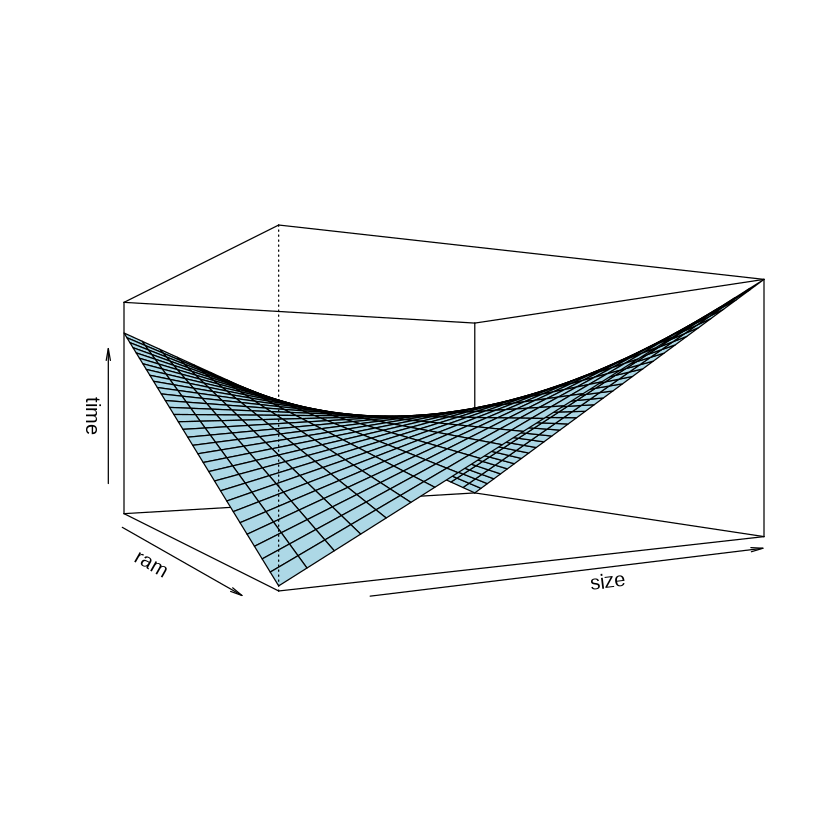

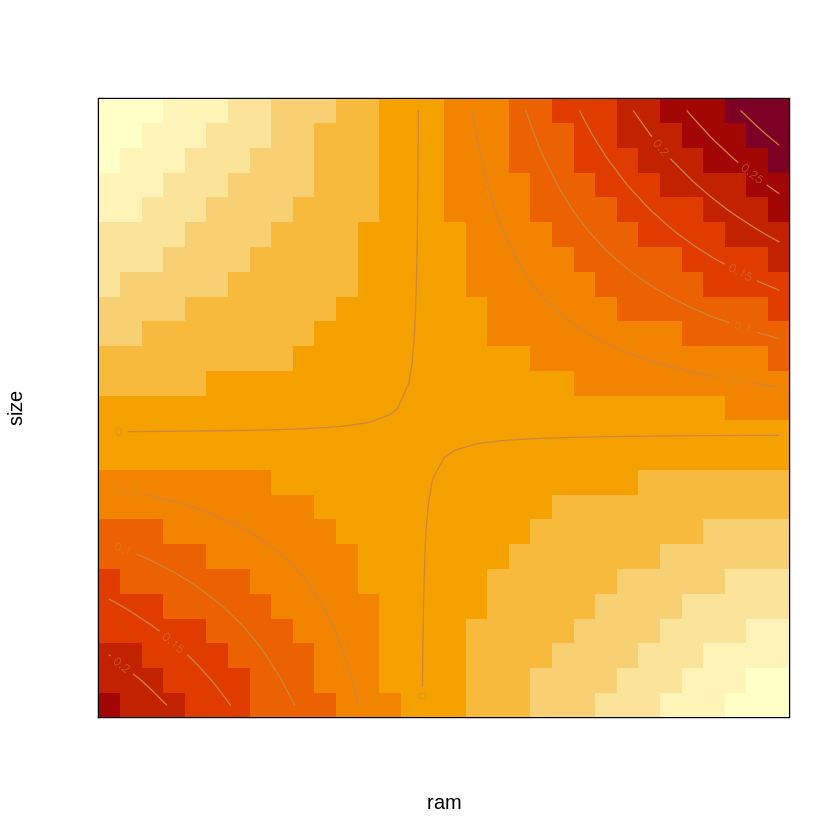

In [ ]:
x=seq(3.1,6.2,by=0.1)
y=seq(45,165,by=5)
impl = "1"
f = function(x,y){
    new.x=data.frame( x0=rep(impl,times=length(x)),x1=x,x2=y)
    colnames(new.x) <- c("implementation", "ram","size")

    predict(model_quantit_1, new.x)
}

# with implementation set to "1"
z = outer(x,y,f)
persp(x,y,z,theta=60,phi=0,expand=0.5,col="lightblue", xlab="ram",ylab="size",zlab="time")
image(x,y,z,axes=F,xlab="ram",ylab="size")

contour(x,y,z,levels=seq(0,3,by=0.05),add=T,col="peru")
axis(1,at=seq(-1,1,by=1),labels=c(3.1,4.6,6.2))
axis(2,at=seq(-1,1,by=1),labels=c(50,100,150))
box()

According to contour at implementation=1 (numpy implementation) the minimum is at (ram, size) = (3.1,165) and (ram, size) = (6.2,45)

In [ ]:
y1 = predict(model_quantit_1, data.frame(implementation="1", ram=3.1, size=165))
y2 = predict(model_quantit_1, data.frame(implementation="1", ram=6.2, size=45))
y = rbind(y1, y2)
y

,1
y1,-0.2876863
y2,-0.2790358


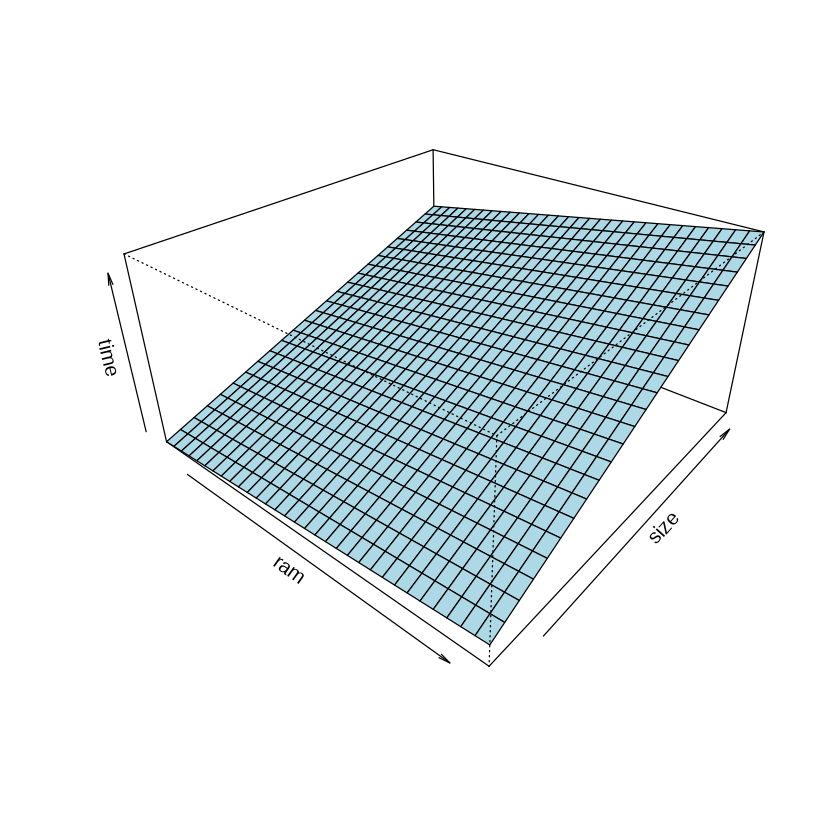

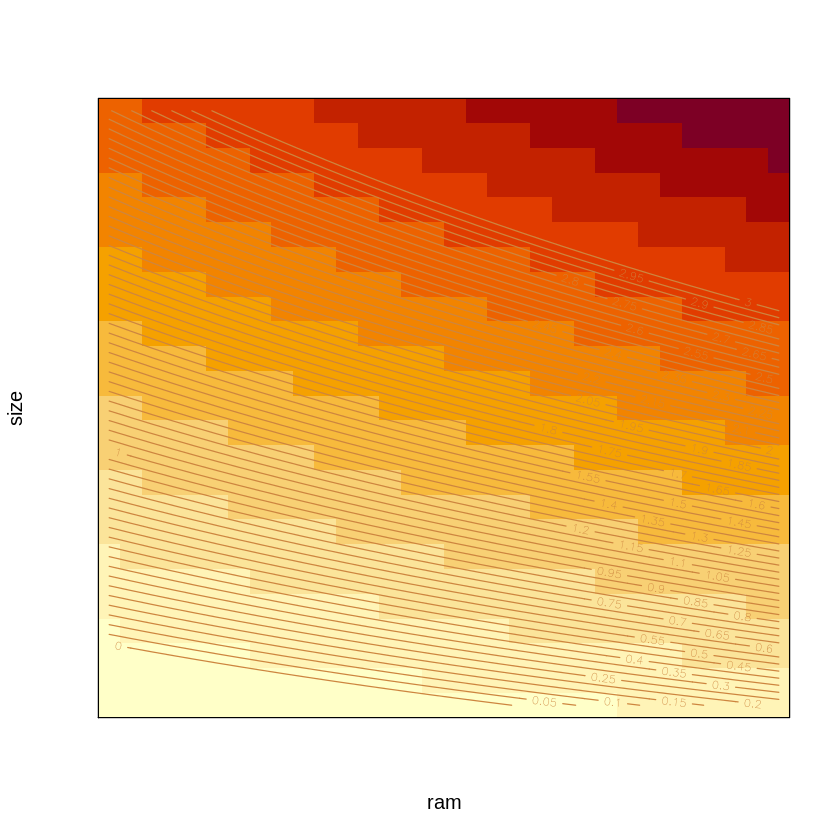

In [ ]:
x=seq(3.1,6.2,by=0.1)
y=seq(45,165,by=5)
impl = "-1"
f = function(x,y){
    new.x=data.frame( x0=rep(impl,times=length(x)),x1=x,x2=y)
    colnames(new.x) <- c("implementation", "ram","size")

    predict(model_quantit_1, new.x)
}

# with implementation set to "-1"
z = outer(x,y,f)
persp(x,y,z,theta=40,phi=30,expand=0.5,col="lightblue", xlab="ram",ylab="size",zlab="time")
image(x,y,z,axes=F,xlab="ram",ylab="size")

contour(x,y,z,levels=seq(0,3,by=0.05),add=T,col="peru")
axis(1,at=seq(-1,1,by=1),labels=c(3.1,4.6,6.2))
axis(2,at=seq(-1,1,by=1),labels=c(50,100,150))
box()

According to contour at implementation=-1 (own implementation) the minimum is at (ram, size) = (3.1,45). The minumum is:

In [ ]:
y = predict(model_quantit_1, data.frame(implementation="-1", ram=3.1, size=45))
y

1 
-0.314413

It is obvious, that by increasing intervals by 10 % we have violated the model assumption. Or that the model was wrong.